In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as st

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

### Import the Data

In [2]:
start_date_f = "2021-10-01"
start_date_p = "2021-10-02"
end_date = "2023-11-08"

# Create a boolean mask based on the date range
dates = lambda df : (df.index >= start_date_f) & (df.index <= end_date)
dates_p = lambda df : (df.index >= start_date_p) & (df.index <= end_date)

In [3]:
# Target variable (stationary)
passengers_df = pd.read_csv("passengers_stationary.csv").set_index("datetime")
passengers_df.index = pd.to_datetime(passengers_df.index, format = "ISO8601")

passengers = passengers_df[["total"]].dropna()

# Features
features = pd.read_csv("features.csv").set_index("Unnamed: 0")
features.rename_axis('datetime', inplace = True)
features.index = pd.to_datetime(features.index, format = "ISO8601")

# Relevant events & days
binary = pd.read_csv("data/merged_features-2.csv").set_index("Date")

# Set index to DateTime
binary.index = pd.to_datetime(binary.index, format = "ISO8601")

# Restrict to relevant dates
passengers = passengers[dates_p(passengers)]
features = features[dates(features)]
binary = binary[dates(binary)]

# Drop uneccessary columns
binary.drop(columns = ['bhfs_north', 'bhfs_middle', 'bhfs_south','PPP', 'Retail', 'Traffic', 'Guests',
                    'Population', "Sunshine", "temperature"], inplace = True)

In [4]:
binary.isna().sum()

Public Holiday ZH             0
School Holidays ZH            0
Public Holiday SH             0
School Holidays SH            0
Public Holiday TG             0
School Holidays TG            0
Public Holiday SG             0
School Holidays SG            0
Public Holiday SZ             0
School Holidays SZ            0
Public Holiday ZG             0
School Holidays ZG            0
Public Holiday AG             0
School Holidays AG            0
clear-night                   0
cloudy                        0
fog                           0
partly-cloudy-day             0
partly-cloudy-night           0
rain                          0
snow                          0
wind                          0
Weekday_Friday                0
Weekday_Monday                0
Weekday_Saturday              0
Weekday_Sunday                0
Weekday_Thursday              0
Weekday_Tuesday               0
Weekday_Wednesday             0
stores_closed_on_that_day    98
dtype: int64

In [5]:
# Fillna (why is it na?)
binary.stores_closed_on_that_day = binary.stores_closed_on_that_day.fillna(0)

# Remove duplicated labels (why duplicated labels?)
binary = binary[~binary.index.duplicated(keep="first")]

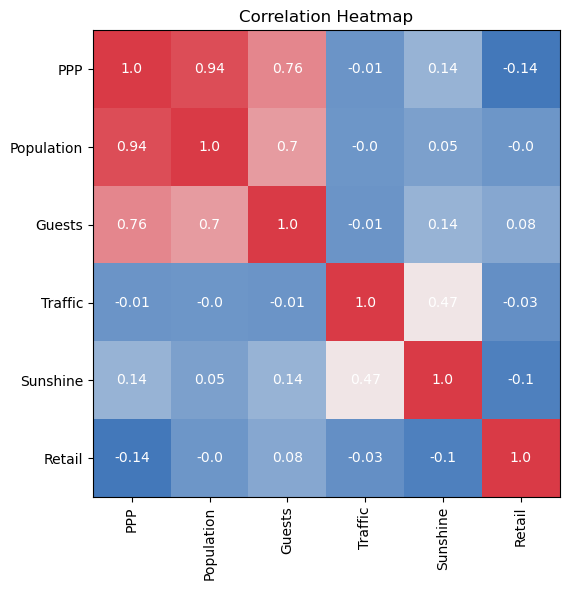

In [6]:
# Show correlation matrix
correlation_matrix = features.corr().round(2)


# Visualize the correlation in a heatmap and annotate

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(correlation_matrix, cmap=sns.diverging_palette(250, 10, center="light",as_cmap=True))
ax.set_xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
ax.set_yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Loop over data dimensions and create text annotations.
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, correlation_matrix.iloc[i, j],
                       ha="center", va="center", color="w")

# Set labels and title
ax.set_title('Correlation Heatmap')
fig.tight_layout()
plt.show()

# Data normalization

In [7]:
# Apply log to the non binary features as all were skewed
features = np.log(features)

# Apply same diff transformation to hourly data as to target
features["Traffic"] = features["Traffic"].diff(24)
features["Sunshine"] = features["Sunshine"].diff(24)
features = features.dropna()

# Merge features
features = pd.merge(features, binary, left_index = True, right_index = True, how = "left")

In [8]:
# Some data is missing as log could not be applied to 0
passengers = passengers.resample("H").sum().fillna(0)

In [9]:
# Split into training and test split
n_splits = 2
tscv = TimeSeriesSplit(n_splits)

y = passengers[["total"]].copy()
X = features.copy()

for train_index, test_index in tscv.split(passengers):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [10]:
# Standardize the Data to obtain better results
# Only standardize non binary data
non_binary = ['PPP', 'Population', 'Guests', 'Traffic', 'Sunshine', 'Retail']
X_train_nb = X_train[non_binary]
X_test_nb = X_test[non_binary]

# Standardize data
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_nb), columns = X_train_nb.columns).set_index(X_train_nb.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_nb), columns = X_test_nb.columns).set_index(X_test_nb.index)

# Concatenate with dummy variables
X_train_scaled = pd.merge(X_train_scaled, X_train[binary.columns], how = "left", left_index = True, right_index = True)
X_test_scaled = pd.merge(X_test_scaled, X_test[binary.columns], how = "left", left_index = True, right_index = True)

# Building the model

Use Lasso to find most important features

In [11]:
from sklearn.linear_model import LassoCV

In [12]:
# Use TimeSeriesSplit for cross-validation
tscv_cv = TimeSeriesSplit(n_splits=3) 

# Apply LassoCV
lasso_cv = LassoCV(alphas=np.logspace(-3, 3, 200), cv=tscv_cv)
lasso_cv.fit(X_train_scaled, y_train.values.ravel())

# Display the selected alpha
print(f"Selected Alpha: {lasso_cv.alpha_: 0.5f}")

# Examine coefficents
coefficients_df = pd.DataFrame({"Coefficient": lasso_cv.coef_}, index = X_train_scaled.columns)
# Show relevant and irrelevant coffecients
zero_coefficents = coefficients_df[coefficients_df["Coefficient"] == 0]
non_zero_coefficents = coefficients_df[coefficients_df["Coefficient"] != 0]
print(f"Lasso dropped {zero_coefficents.shape[0]} coefficients")

Selected Alpha:  0.00430
Lasso dropped 24 coefficients


<Figure size 1000x600 with 0 Axes>

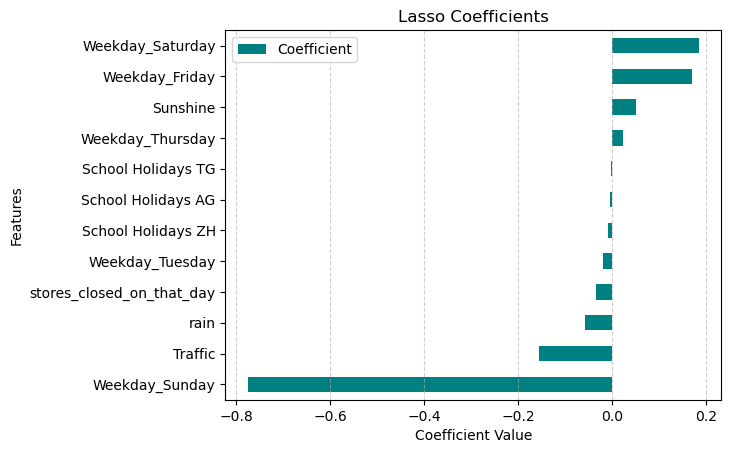

In [13]:
# ToDo: Different colors
# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
non_zero_coefficents.sort_values(by='Coefficient').plot.barh(color='teal')
plt.title('Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6);

In [14]:
# Drop the zero coefficents
non_zero_coef = list(non_zero_coefficents.index)
X_train_scaled = X_train_scaled[non_zero_coef].copy()
X_test_scaled = X_test_scaled[non_zero_coef].copy()

## Training the LSTM

Did not use RNN because of vanishing gradient. Should not forget what happened 10 hours before. Also see ACF

In [15]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

2023-11-26 20:34:00.304640: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-26 20:34:00.308342: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 20:34:00.346734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 20:34:00.346776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 20:34:00.348101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Optimize model

In [16]:
# Define the validation data
# Set the number of time steps for validation
validation_percentage = 0.2

# Calculate the index to split the data
split_index = int(len(X_train_scaled) * (1 - validation_percentage))

# Split the data
X_train_scaled_split, X_val = X_train_scaled[:split_index], X_train_scaled[split_index:]
y_train_split, y_val = y_train[:split_index], y_train[split_index:]

In [17]:
def build_sequence(df, sequence_length = 24):

    # Create sequences for LSTM
    sequences = [(list(df.index[i:i+sequence_length]), df.iloc[i:i+sequence_length]) for i in range(len(df)-sequence_length+1)]
    # Convert sequences to NumPy array
    X_seq = np.array([seq[1].values for seq in sequences])
    indices = np.array([seq[0] for seq in sequences])
    return X_seq, indices

In [18]:
X_train_scaled_split_seq, X_train_scaled_split_seq_indice = build_sequence(X_train_scaled_split)
y_train_split_seq, y_train_scaled_split_seq_indice = build_sequence(y_train_split)
X_val_seq, X_val_seq_indice = build_sequence(X_val)
y_val_seq, y_val_seq_indice = build_sequence(y_val)
X_test_scaled_seq, X_test_scaled_seq_indice = build_sequence(X_test_scaled)

In [24]:
def build_model(hp):
    
    model = keras.Sequential()
    model.add(LSTM(units=50, input_shape=(24,12)))
    
    # Tune the number of Dense layers and the number of neurons
    for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=1)):
        
        model.add(Dense(units=hp.Int("units_" + str(i), min_value=32, max_value=256, step=32),
                               activation=hp.Choice("activation_" + str(i), values=["relu", "sigmoid", "tanh", "linear"])))
        
        # Add dropout layer with a tunable rate
        model.add(layers.Dropout(rate=hp.Float("dropout_" + str(i), min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer. Apply linear activation function as scaled passenger target can have positive and negative values
    model.add(layers.Dense(1, activation = "linear")) 

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  loss="mse", metrics=["mse"]) 

    return model
    

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective= "mse",
    max_trials= 7
)


# Perform hyperparameter search
tuner.search(X_train_scaled_split_seq, y_train_split_seq,
             epochs= 10, 
             validation_data=(X_val_seq, y_val_seq))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

Reloading Tuner from ./untitled_project/tuner0.json


In [55]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3)  
# Train the best model with a larger number of epochs
history = best_model.fit(X_train_scaled_split_seq, y_train_split_seq, epochs=100, validation_data=(X_val_seq, y_val_seq),callbacks=[early_stopping])

Epoch 1/100
307/307 [==============================] - 7s 23ms/step - loss: 0.4864 - mse: 0.4864 - val_loss: 0.5374 - val_mse: 0.5374
Epoch 2/100
307/307 [==============================] - 7s 24ms/step - loss: 0.4852 - mse: 0.4852 - val_loss: 0.5367 - val_mse: 0.5367
Epoch 3/100
307/307 [==============================] - 8s 25ms/step - loss: 0.4833 - mse: 0.4833 - val_loss: 0.5392 - val_mse: 0.5392
Epoch 4/100
307/307 [==============================] - 7s 24ms/step - loss: 0.4832 - mse: 0.4832 - val_loss: 0.5371 - val_mse: 0.5371
Epoch 5/100
307/307 [==============================] - 7s 24ms/step - loss: 0.4825 - mse: 0.4825 - val_loss: 0.5368 - val_mse: 0.5368


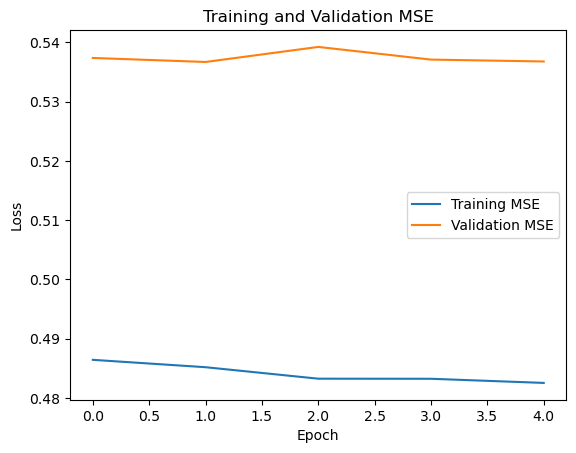

In [56]:
# Plot training and validation loss
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making predictions

In [47]:
# Generate predictions (not yet converted back to normal data)
def generate_prediction(X, index):
    # Change to best model
    start = index[0][-1]
    end = index[-1][-1]
    hourly_indices = pd.date_range(start=start, end=end, freq='H')
    predicted_scaled = pd.DataFrame(best_model.predict(X), hourly_indices)
    predicted_scaled.columns = ["Prediction"]
    return predicted_scaled

In [48]:
# invert differenced value
def inverse_difference(yhat, history = passengers_df, interval=24):
    # Merge the logged actual data and the prediction
    x = pd.merge(history[["log"]], yhat, left_index = True, right_index = True)
    
    # Shift by the number of periods used to remove the seasonality
    x["Shifted"] = x.log.shift(interval)
    # Drop the 24 days for which no previous season available
    x = x.dropna()
    # Show to actual prediction by summing the prediction and the past seasonal value and reversing the log transformation
    x["pred"] = np.exp(x.Prediction+x.Shifted)
    # Show the actual data by reversing the log transformation
    x["actual"] = np.exp(x.log)
    return x

In [52]:
# Showing predictions of test data
predicted_scaled = generate_prediction(X_test_scaled_seq, X_test_scaled_seq_indice)
pred = inverse_difference(predicted_scaled)

192/192 [==============================] - 2s 8ms/step


In [53]:
pred

,log,Prediction,Shifted,pred,actual
2023-02-27 08:00:00,7.858254,-0.836022,6.714171,357.147268,2587.0
2023-02-27 09:00:00,8.119696,-0.782645,7.470224,802.377797,3360.0
2023-02-27 10:00:00,8.431635,-0.734339,7.738052,1100.712724,4590.0
2023-02-27 11:00:00,8.739216,-0.687774,7.987864,1480.432770,6243.0
2023-02-27 12:00:00,8.670772,-0.652302,8.236950,1967.754256,5830.0
...,...,...,...,...,...
2023-11-07 20:00:00,7.531016,0.096183,7.546446,2085.219589,1865.0
2023-11-07 21:00:00,7.242082,0.096331,7.015712,1226.651177,1397.0
2023-11-07 22:00:00,6.349139,0.101806,6.304449,605.621442,572.0
2023-11-07 23:00:00,5.472271,0.109252,5.552960,287.784388,238.0


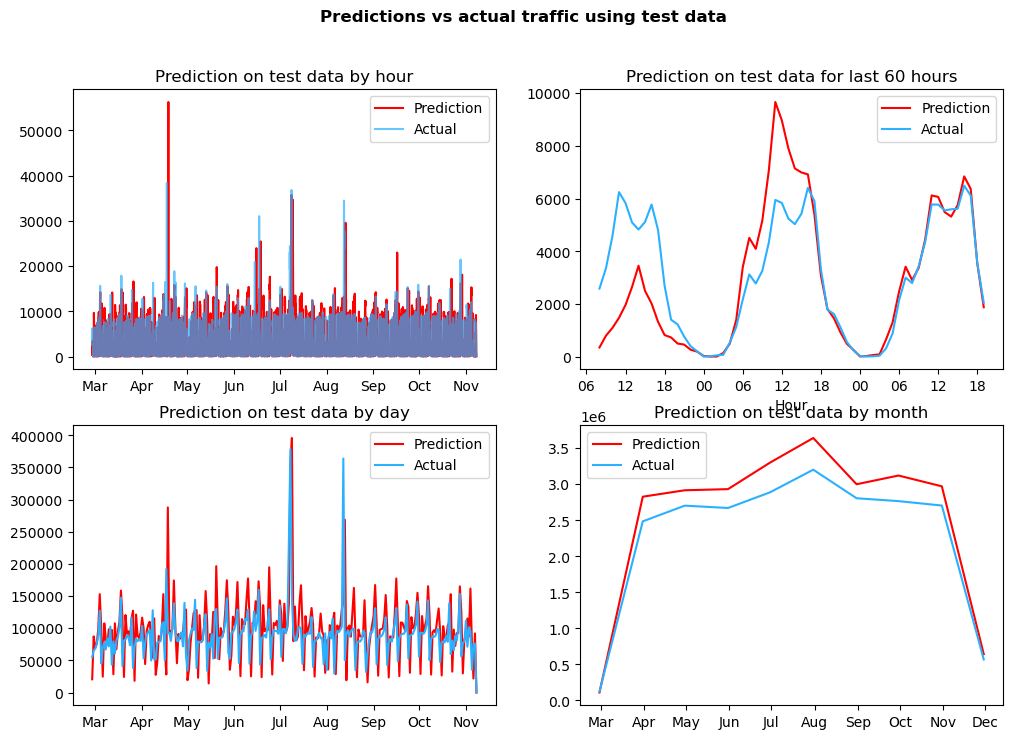

In [54]:
from matplotlib.dates import DateFormatter
# Plotting predictions
fig, axs = plt.subplots(2,2, figsize= (12,8))
fig.suptitle("Predictions vs actual traffic using test data", fontweight = "bold")
# Total predictions
axs[0,0].plot(pred.pred, c="r", label = "Prediction")
axs[0,0].plot(pred.actual, c='#2ab0ff', label = "Actual", alpha = 0.7)
axs[0,0].set_title("Prediction on test data by hour")
axs[0,0].legend()

# Last 60 hours to see whether daily seasonality captured
axs[0,1].plot(pred.pred.head(60), c='r', label = "Prediction")
axs[0,1].plot(pred.actual.head(60), c='#2ab0ff', label = "Actual")
axs[0,1].set_title("Prediction on test data for last 60 hours")
axs[0,1].set_xlabel("Hour")
axs[0,1].legend()

# By day
axs[1,0].plot(pred.resample("D").sum().pred, c='r', label = "Prediction")
axs[1,0].plot(pred.resample("D").sum().actual, c='#2ab0ff', label = "Actual")
axs[1,0].set_title("Prediction on test data by day")
axs[1,0].legend();

# By month
axs[1,1].plot(pred.resample("M").sum().pred, c='r', label = "Prediction")
axs[1,1].plot(pred.resample("M").sum().actual, c='#2ab0ff', label = "Actual")
axs[1,1].set_title("Prediction on test data by month")
axs[1,1].legend();

# Format x-Axis
date_form_hour = DateFormatter("%b")
date_form_60 = DateFormatter("%H")
axs[0,0].xaxis.set_major_formatter(date_form_hour)
axs[0,1].xaxis.set_major_formatter(date_form_60)
axs[1,1].xaxis.set_major_formatter(date_form_hour)
axs[1,0].xaxis.set_major_formatter(date_form_hour)

## ToDo:
- One dataset <br>
- Schreiben in Word Dokument <br>
- ## Decision tree machen <br>